## Import Libraries

In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
import re
import math
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import csr_matrix

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

from nltk.util import ngrams
from nltk import pos_tag

from nltk.sentiment import SentimentIntensityAnalyzer


%matplotlib inline
pd.options.display.max_colwidth=500

## Load Data

In [4]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)

val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)

test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

In [5]:
# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


## Helper Functions

In [6]:
def compute_cosine_similarity(v1, v2):
    norm_v1 = norm(v1)
    norm_v2 = norm(v2)

    # Handle zero vectors
    if norm_v1 == 0 or norm_v2 == 0:
        return 0

    # Handle NaN or Inf values
    if np.any(np.isnan(v1)) or np.any(np.isnan(v2)) or np.any(np.isinf(v1)) or np.any(np.isinf(v2)):
        return 0

    return np.dot(v1, v2) / (norm_v1 * norm_v2)

In [7]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [8]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [9]:
def get_wordnet_pos(word):
    """Get WordNet POS tag for lemmatization."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def calculate_avg_dialogue_length(character_docs):
    """
    Calculate the average dialogue length for each character.

    ::character_docs:: Dictionary where keys are character names and values are their lines concatenated.

    Returns:
    - A dictionary where keys are character names and values are their avg dialogue length.
    """
    avg_lengths = {}
    for character, lines in character_docs.items():
        # Split lines into individual sentences
        lines_split = lines.split("_EOL_")

        # Count total tokens and total lines
        total_tokens = sum(len(line.split()) for line in lines_split if line.strip())
        total_lines = len([line for line in lines_split if line.strip()])

        # Calculate average dialogue length
        if total_lines > 0:
            avg_lengths[character] = total_tokens / total_lines
        else:
            avg_lengths[character] = 0  # Handle cases with no lines
    return avg_lengths

## Best approaches from previous questions


In [11]:
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [12]:
def pre_process(character_text, params={}):
    """
    Pre-process all the concatenated lines of a character with added lemmatization.

    ::character_text:: a string with all of one character's lines.
    ::tokenization:: tokenization method ("whitespace", "nltk", "regex").
    ::case_normalization:: whether to lowercase tokens.
    ::stopword_removal:: whether to remove stopwords.
    ::stemming:: type of stemming ("porter", "snowball", "none").
    ::lemmatization:: whether to apply lemmatization.
    ::punctuation_removal:: whether to remove punctuation.
    """

    if params:
      tokenization, case_normalization, stopword_removal, stemming, lemmatization, punctuation_removal = params.values()
    else:
      tokenization="regex"
      case_normalization=True
      stopword_removal=True
      stemming=True
      lemmatization=True
      punctuation_removal=True

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer() if lemmatization else None

    # Tokenization
    if tokenization == "nltk":
        tokens = nltk.word_tokenize(character_text)
    elif tokenization == "regex":
        tokens = re.findall(r'\b\w+\b', character_text)

    # Case normalization
    if case_normalization:
        tokens = [token.lower() for token in tokens]

    # Stopword removal
    if stopword_removal:
        tokens = [token for token in tokens if token not in stop_words]

    # Punctuation removal
    if punctuation_removal:
        tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Lemmatization
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # Stemming
    if stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [13]:
sia = SentimentIntensityAnalyzer()

def to_feature_vector_dictionary(character_doc, params={}, extra_features={}):
    """
    Converts a list of pre-processed tokens and extra features
    into a feature dictionary based on specified parameters.

    ::character_doc:: A list of pre-processed tokens.
    ::extra_features:: Any extra features for the character to be added to the feature vector dict.
    ::params:: Dictionary specifying the feature extraction settings.
    """
    counts = Counter(character_doc)

    # Token counts with n-grams
    if "ngrams" in params:
      for n in range(1, params["ngrams"]):
          ngram_list = ["_".join(gram) for gram in nltk.ngrams(character_doc, n)]
          counts.update(Counter(ngram_list))


    # POS tag counts
    if params.get("pos_tags", False):
      pos_tags = nltk.pos_tag(character_doc)
      pos_counts = Counter(tag for _, tag in pos_tags)
      counts.update(pos_counts)

    # Sentiment analysis
    if params.get("sentiment", False):
      text = " ".join(character_doc)
      sentiment_scores = sia.polarity_scores(text)
      counts["sentiment_pos"] = sentiment_scores["pos"]
      counts["sentiment_neg"] = sentiment_scores["neg"]
      counts["sentiment_neu"] = sentiment_scores["neu"]
      counts["sentiment_compound"] = sentiment_scores["compound"]

    # Average dialogue length
    if params.get("avg_dialogue_length", False):
      counts["avg_dialogue_length"] = extra_features["avg_dialogue_length"]

    return dict(counts)

In [14]:
tfidf_transformer = TfidfTransformer()
corpusVectorizer = DictVectorizer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False, feature_params={}, matrix_params={}):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Enhanced with TF-IDF transformation and optional feature selection.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data).
    ::max_features:: max number of features to retain (used for feature selection).
    ::use_tfidf:: whether to apply TF-IDF transformation.
    """
    global feature_selector

    if matrix_params:
      use_tfidf, max_features = matrix_params.values()
    else:
      use_tfidf = True
      max_features = 100

    # Convert documents to feature dictionaries
    feature_dicts = [to_feature_vector_dictionary(doc, params=feature_params, extra_features={"avg_dialogue_length": avg_lengths[name]}) for name, doc in corpus]

    if fitting:
        # Fit vectorizer
        corpusVectorizer.fit(feature_dicts)

        # Transform the data
        feature_matrix = corpusVectorizer.transform(feature_dicts)

        # Apply TF-IDF if enabled
        if use_tfidf:
            tfidf_transformer.fit(feature_matrix)
            feature_matrix = tfidf_transformer.transform(feature_matrix)

        # Apply feature selection if max_features is set
        if max_features is not None:
            feature_selector = SelectKBest(chi2, k=max_features)
            feature_selector.fit(feature_matrix, [label for label, _ in corpus])
            feature_matrix = feature_selector.transform(feature_matrix)
    else:
        # Transform the data without fitting
        feature_matrix = corpusVectorizer.transform(feature_dicts)

        # Apply TF-IDF if enabled
        if use_tfidf:
            feature_matrix = tfidf_transformer.transform(feature_matrix)

        # Apply feature selection if it was previously fitted
        if feature_selector is not None:
            feature_matrix = feature_selector.transform(feature_matrix)

    return feature_matrix

## Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

### Implement Grid Search function

In [15]:
from itertools import product

def grid_search(grid_type, parameter_grid, train_character_docs, val_character_docs, best_pre_processing_config=None, best_feature_extraction_config=None):
    """
    Perform a grid search over the parameter grid and return the best configuration based on mean rank.

    ::grid_type:: The type of grid search ('preprocessing', 'feature_extraction', 'matrix_transformation').
    ::parameter_grid:: Dictionary with parameter names as keys and possible values as lists for each grid search type.
    ::train_character_docs:: Dictionary of character names and their corresponding training text.
    ::val_character_docs:: Dictionary of character names and their corresponding validation text.
    ::compute_IR_evaluation_scores:: Function to compute evaluation scores based on the generated matrices.
    ::pre_process:: Function for preprocessing text with given parameters.
    ::create_document_matrix_from_corpus:: Function to create a document matrix from a corpus based on feature extraction and transformation configurations.
    ::best_pre_processing_config:: The configuration for pre-processing (optional, only used for 'feature_extraction' and 'matrix_transformation').
    ::best_feature_extraction_config:: The configuration for feature extraction (optional, only used for 'matrix_transformation').

    Returns:
    - best_config: The best parameter configuration found during the grid search.
    - best_mean_rank: The best mean rank achieved.
    - best_accuracy: The best accuracy achieved.
    """

    # Generate all combinations of parameter settings
    keys, values = zip(*parameter_grid.items())
    configurations = [dict(zip(keys, v)) for v in product(*values)]

    print('Total configurations to test:', len(configurations))
    print()

    best_config = None
    best_mean_rank = float('inf')
    best_accuracy = 0.0

    for it, config in enumerate(configurations):
        print(f"Testing configuration {it+1}: {config}")

        # Prepare training and validation corpora using the current configuration
        if grid_type == "preprocessing":
            # Pre-process the documents using the current configuration
            train_corpus = [(name, pre_process(doc, config)) for name, doc in train_character_docs.items()]
            val_corpus = [(name, pre_process(doc, config)) for name, doc in val_character_docs.items()]
            train_labels = [name for name, doc in train_corpus]
            val_labels = [name for name, doc in val_corpus]
        elif grid_type == "feature_extraction":
            # Pre-process documents first
            train_corpus = [(name, pre_process(doc, best_pre_processing_config)) for name, doc in train_character_docs.items()]
            val_corpus = [(name, pre_process(doc, best_pre_processing_config)) for name, doc in val_character_docs.items()]
            train_labels = [name for name, doc in train_corpus]
            val_labels = [name for name, doc in val_corpus]
            # Extract features using the current configuration
            feature_dicts = [to_feature_vector_dictionary(doc, params=config, extra_features={"avg_dialogue_length": avg_lengths[name]}) for name, doc in train_corpus]
            # Check for empty feature dictionaries
            if all(not features for features in feature_dicts):
                print(f"Skipping configuration {config} - No features generated.")
                continue
        elif grid_type == "matrix_transformation":
            # Pre-process and feature extraction using the previous configurations
            train_corpus = [(name, pre_process(doc, best_pre_processing_config)) for name, doc in train_character_docs.items()]
            val_corpus = [(name, pre_process(doc, best_pre_processing_config)) for name, doc in val_character_docs.items()]
            train_labels = [name for name, doc in train_corpus]
            val_labels = [name for name, doc in val_corpus]

        # Generate document matrices based on the grid type
        if grid_type == "preprocessing":
            train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True)
            val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)
        elif grid_type == "feature_extraction":
            train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True, feature_params=config)
            val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_params=config)
        elif grid_type == "matrix_transformation":
            train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True, feature_params=best_feature_extraction_config, matrix_params=config)
            val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_params=best_feature_extraction_config)

        # Compute evaluation scores
        mean_rank, _, accuracy, _ = compute_IR_evaluation_scores(train_matrix, val_matrix, train_labels, val_labels)

        # Check if this is the best configuration
        if mean_rank < best_mean_rank:
            best_mean_rank = mean_rank
            best_config = config
            best_accuracy = accuracy

        print('__________________________________________________________________________\n')

    print("Best configuration:", best_config)
    print("Best mean rank:", best_mean_rank)
    print("Best accuracy:", best_accuracy)

    return best_config

### Prepare Data

In [16]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}


In [17]:
avg_lengths = calculate_avg_dialogue_length(train_character_docs)
avg_lengths

{'SHIRLEY': 9.333333333333334,
 'OTHER': 7.91,
 'JACK': 11.356666666666667,
 'RONNIE': 9.016666666666667,
 'TANYA': 9.97,
 'SEAN': 8.56,
 'ROXY': 9.396666666666667,
 'MAX': 11.946666666666667,
 'IAN': 10.556666666666667,
 'JANE': 9.426666666666666,
 'STACEY': 9.783333333333333,
 'PHIL': 9.43,
 'HEATHER': 9.873333333333333,
 'MINTY': 10.033333333333333,
 'CHRISTIAN': 9.926666666666666,
 'CLARE': 11.076666666666666}

### Preprocessing Grid Search

In [18]:
preprocessing_grid = {
    "tokenization": ["nltk", "regex"],
    "case_normalization": [True, False],
    "stopword_removal": [True, False],
    "stemming": [True, False],
    "lemmatization": [True, False],
    "punctuation_removal": [True, False],
}

best_preprocessing_config = grid_search(
    grid_type="preprocessing",
    parameter_grid=preprocessing_grid,
    train_character_docs=train_character_docs,
    val_character_docs=val_character_docs,
)

Total configurations to test: 64

Testing configuration 1: {'tokenization': 'nltk', 'case_normalization': True, 'stopword_removal': True, 'stemming': True, 'lemmatization': True, 'punctuation_removal': True}
mean rank 1.8125
mean cosine similarity 0.5672143228159775
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing configuration 2: {'tokenization': 'nltk', 'case_normalization': True, 'stopword_removal': True, 'stemming': True, 'lemmatization': True, 'punctuation_removal': False}
mean rank 1.75
mean cosine similarity 0.6493515901745279
15 correct out of 16 / accuracy: 0.9375
__________________________________________________________________________

Testing configuration 3: {'tokenization': 'nltk', 'case_normalization': True, 'stopword_removal': True, 'stemming': True, 'lemmatization': False, 'punctuation_removal': True}
mean rank 1.8125
mean cosine similarity 0.5672143228159775
14 correct out of 16 / accuracy: 0.8

In [19]:
best_preprocessing_config

{'tokenization': 'regex',
 'case_normalization': True,
 'stopword_removal': True,
 'stemming': False,
 'lemmatization': True,
 'punctuation_removal': True}

### Feature Extraction Grid Search

In [20]:
feature_extraction_grid = {
    "ngrams": [1, 2, 3],
    "pos_tags": [True, False],
    "sentiment": [True, False],
    "avg_dialogue_length": [True, False]
}

best_feature_extraction_config = grid_search(
    grid_type="feature_extraction",
    parameter_grid=feature_extraction_grid,
    train_character_docs=train_character_docs,
    val_character_docs=val_character_docs,
    best_pre_processing_config=best_preprocessing_config
)

Total configurations to test: 24

Testing configuration 1: {'ngrams': 1, 'pos_tags': True, 'sentiment': True, 'avg_dialogue_length': True}
mean rank 1.5625
mean cosine similarity 0.5684822024949662
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing configuration 2: {'ngrams': 1, 'pos_tags': True, 'sentiment': True, 'avg_dialogue_length': False}
mean rank 1.5625
mean cosine similarity 0.5684822024949662
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing configuration 3: {'ngrams': 1, 'pos_tags': True, 'sentiment': False, 'avg_dialogue_length': True}
mean rank 1.5625
mean cosine similarity 0.5684822024949662
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing configuration 4: {'ngrams': 1, 'pos_tags': True, 'sentiment': False, 'avg_dialogue_length': False}
mean rank 1.5625
mea

In [21]:
best_feature_extraction_config

{'ngrams': 3, 'pos_tags': True, 'sentiment': True, 'avg_dialogue_length': True}

### Matrix transformation Grid Search

In [22]:
matrix_transformation_grid = {
    "use_tfidf": [True, False],
    "max_features": [50, 90, 100, 200]
}

best_matrix_transformation_config = grid_search(
    grid_type="matrix_transformation",
    parameter_grid=matrix_transformation_grid,
    train_character_docs=train_character_docs,
    val_character_docs=val_character_docs,
    best_pre_processing_config=best_preprocessing_config,
    best_feature_extraction_config=best_feature_extraction_config
)

Total configurations to test: 8

Testing configuration 1: {'use_tfidf': True, 'max_features': 50}
mean rank 1.5
mean cosine similarity 0.6118822514398076
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing configuration 2: {'use_tfidf': True, 'max_features': 90}
mean rank 1.375
mean cosine similarity 0.586484991015847
15 correct out of 16 / accuracy: 0.9375
__________________________________________________________________________

Testing configuration 3: {'use_tfidf': True, 'max_features': 100}
mean rank 1.375
mean cosine similarity 0.5719363788087589
15 correct out of 16 / accuracy: 0.9375
__________________________________________________________________________

Testing configuration 4: {'use_tfidf': True, 'max_features': 200}
mean rank 1.625
mean cosine similarity 0.5237830608136561
14 correct out of 16 / accuracy: 0.875
__________________________________________________________________________

Testing config

In [23]:
best_matrix_transformation_config

{'use_tfidf': True, 'max_features': 90}

## Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

In [24]:
train_corpus = [(name, pre_process(doc, best_preprocessing_config)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in train_corpus]

val_corpus = [(name, pre_process(doc, best_preprocessing_config)) for name, doc in val_character_docs.items()]
val_labels = [name for name, doc in val_corpus]

train_matrix = create_document_matrix_from_corpus(train_corpus, fitting=True, feature_params=best_feature_extraction_config, matrix_params=best_matrix_transformation_config)
val_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_params=best_feature_extraction_config)

mean_rank, mean_cosine, accuracy, df = compute_IR_evaluation_scores(train_matrix, val_matrix, train_labels, val_labels)

mean rank 1.375
mean cosine similarity 0.586484991015847
15 correct out of 16 / accuracy: 0.9375


<ipython-input-8-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-8-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-8-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-8-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-8-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
<ipython-input-8-89ca39ec0276>:10: UserWarning: Bo

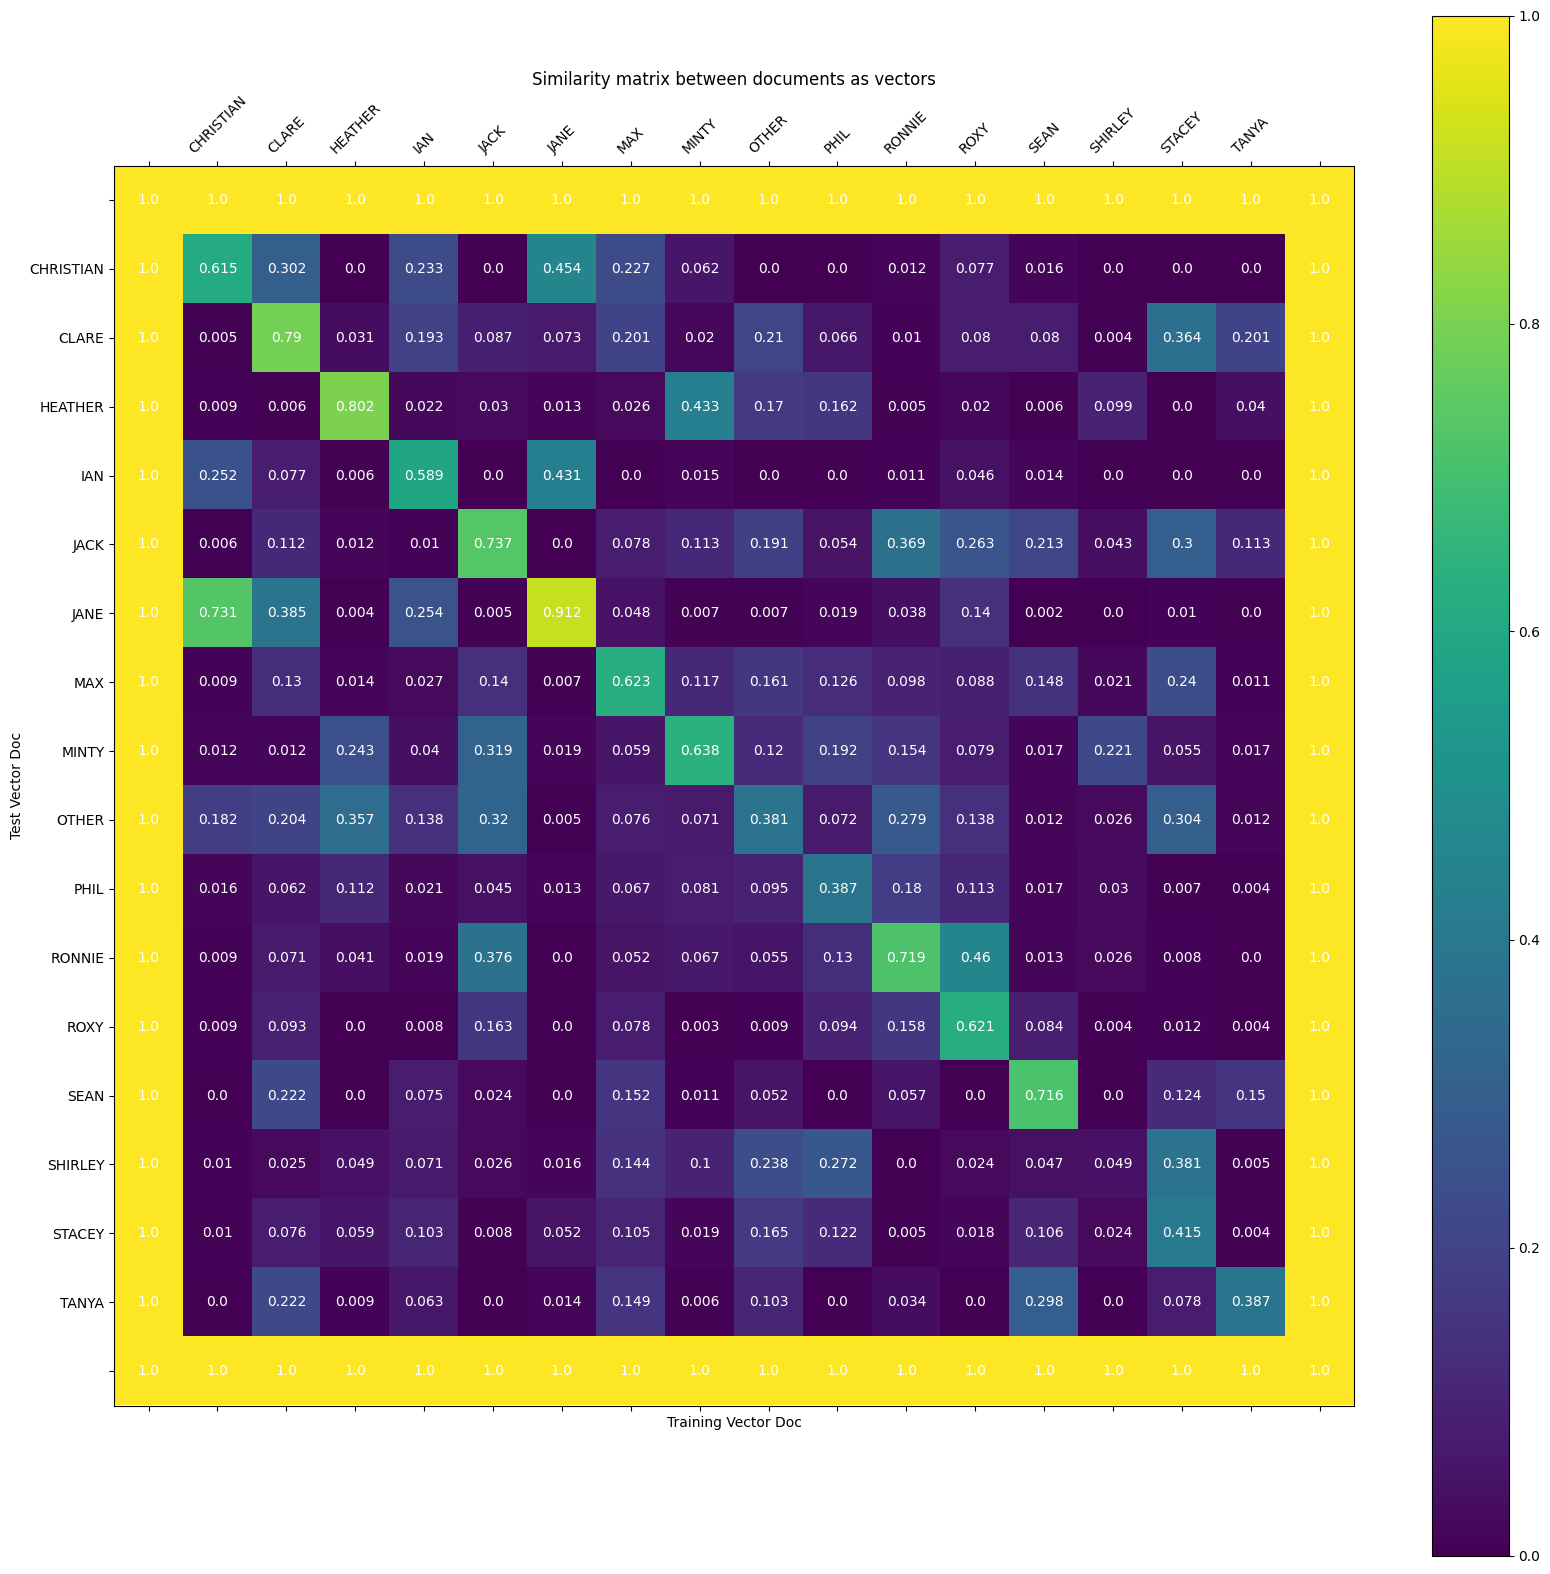

In [25]:
plot_heat_map_similarity(df)

## Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 50 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [26]:
print(best_preprocessing_config)
print(best_feature_extraction_config)
print(best_matrix_transformation_config)

{'tokenization': 'regex', 'case_normalization': True, 'stopword_removal': True, 'stemming': False, 'lemmatization': True, 'punctuation_removal': True}
{'ngrams': 3, 'pos_tags': True, 'sentiment': True, 'avg_dialogue_length': True}
{'use_tfidf': True, 'max_features': 90}


In [28]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words, end="\n")

training_corpus = [(name, pre_process(doc, best_preprocessing_config)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_params=best_feature_extraction_config, matrix_params=best_matrix_transformation_config)

# get the test data using 50 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=50)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words, end="\n")

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, feature_params=best_feature_extraction_config)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079
lines per character {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}
Num. Characters:  

In [29]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.5
mean cosine similarity 0.6245672631334012
13 correct out of 16 / accuracy: 0.8125
